In [1]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import xarray as xr
import pandas as pd
import glob
from datetime import datetime
from eofs.xarray import Eof
import os
from matplotlib import cm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps

### Set Region and Period

In [2]:
Slat = 25
Elat = 50
Slon = 115
Elon = 140

SYR = 2005
EYR = 2013

SEASON = 'MJJAS'

### Get ERE date: YYYYYMMDD

In [3]:
IFILE1 = glob.glob('./OUT/ERE_date_pr_ASOS_KST_'+str(SYR)+str(EYR)+'_'+SEASON+'.nc')
inf1 = xr.open_dataset(IFILE1[0])
ere_data1 = inf1['date'][:]
ere_data2 = xr.DataArray.to_dataframe(ere_data1)
ere_data3 = np.array(ere_data2)
EREDATE = ere_data3.reshape(len(ere_data3)).tolist()
del ere_data1,ere_data2,ere_data3

### Remove Typhoon date from ERE date

In [4]:
tfile = './DATA/typhoon_date.txt'
with open(tfile) as f:
    typhoon = f.readlines()
styphoon = [line.rstrip('\n') for line in typhoon]
TYPHOON = list(map(int, styphoon))

ere_notyphoon_list = sorted(list(set(EREDATE) - set(TYPHOON)))
pd.Series(ere_notyphoon_list)

0      20050505.0
1      20050506.0
2      20050517.0
3      20050518.0
4      20050601.0
          ...    
374    20130913.0
375    20130914.0
376    20130922.0
377    20130929.0
378    20130930.0
Length: 379, dtype: float64

### Get 850 hPa geopotential height data

In [5]:
IFILE2 = glob.glob('./DATA/ERA5_zg850_day_KST_'+str(SYR)+'-'+str(EYR)+'_'+SEASON+'_anom.nc')
inf2 = xr.open_dataset(IFILE2[0])
lat_bnds, lon_bnds = [Elat, Slat], [Slon, Elon]
zg850_data1 = inf2['zg850'].sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))
zg850_data1

<xarray.DataArray 'zg850' (time: 1377, latitude: 101, longitude: 101)>
[14046777 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2005-05-01 2005-05-02 ... 2013-09-30
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 25.5 25.25 25.0
  * longitude  (longitude) float32 115.0 115.2 115.5 115.8 ... 139.5 139.8 140.0

### Subtract first 4 EOF modes 

In [6]:
coslat = np.cos(np.deg2rad(zg850_data1.coords['latitude'].values)).clip(0., 1.)
solver = Eof(zg850_data1, center=False)
var = solver.varianceFraction(neigs=7)
sum(var[:4])*100  # Variance: 83.38% 

<xarray.DataArray 'variance_fractions' ()>
array(83.38674307)

In [7]:
reconstruction = solver.reconstructedField(4)

zg850_2 = xr.DataArray.to_dataframe(reconstruction)
zg850_2 = zg850_2.unstack()
zg850_3 = zg850_2.unstack()
ZG850 = zg850_3.values

### Extract Geopotential data for ERE date

In [8]:
time_1 = inf2['time'][:]
time_2 = xr.DataArray.to_dataframe(time_1)
time_3  = time_2.reset_index(drop=True)
time_3['time'] = time_3['time'].apply(lambda _: datetime.strftime(_,"%Y%m%d"))
time_4 = np.array(time_3)
TIME = time_4.astype(float)
TIME_list = TIME.reshape(len(TIME)).tolist()

ere_ind = [i for i, val in enumerate(TIME_list) if val in ere_notyphoon_list]

DATA = ZG850[ere_ind,:]
eredate_notyphn1 = TIME[ere_ind]
eredate_notyphn = eredate_notyphn1.reshape(len(eredate_notyphn1))

### Find Optial No. Cluster: Shillouette

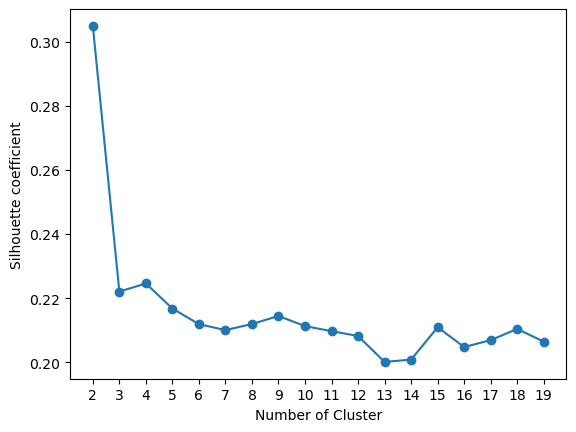

In [9]:
results = []
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state = 0)
    cluster_labels = kmeans.fit_predict(DATA)
    silhouette_avg = silhouette_score(DATA, cluster_labels)
    results.append(silhouette_avg)
    del kmeans,cluster_labels,silhouette_avg

plt.plot(range(2, 20), results, marker='o')
plt.xlabel('Number of Cluster')
plt.xticks(np.arange(2,20))
plt.ylabel('Silhouette coefficient')
plt.show()
plt.close()

### Find Optial No. Cluster: SSE (Elbow Method)

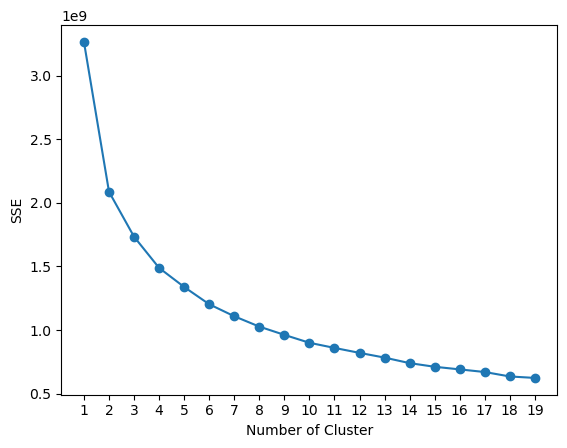

In [10]:
distort = []
xticks=[]
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(DATA)
    distort.append(kmeans.inertia_)
    del kmeans
plt.plot(range(1, 20), distort, marker='o')
plt.xlabel('Number of Cluster')
plt.xticks(np.arange(1,20))
plt.ylabel('SSE')
plt.show()
plt.close()

Considering Shillouette coefficient and SSE, '4' is the optimal number of cluster <br/> Therefore, the ERE dates are splited into four clusters

### Clustering

In [11]:
nclus = 4

kmeans = KMeans(n_clusters=nclus, random_state= 0)
kmeans.fit(DATA)
labels = kmeans.predict(DATA)

npts = []

switch = [1,3,0,2]
for i in switch:
    npts.append(len(eredate_notyphn[labels==i]))
print('number of each cluster',npts)

data_cluster=pd.DataFrame(index=range(max(npts)), columns=['Cluster 1','Cluster 2','Cluster 3','Cluster 4'])

for i, clus in enumerate(switch):
    data_cluster.iloc[:npts[i],i] = eredate_notyphn[labels==clus].tolist()
    data_cluster.iloc[:,i]=pd.to_datetime(data_cluster.iloc[:,i],format='%Y%m%d')
data_cluster

number of each cluster [85, 91, 109, 94]


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,2005-05-06,2005-06-26,2005-05-05,2005-05-17
1,2005-06-01,2005-06-29,2005-05-18,2005-08-08
2,2005-06-02,2005-06-30,2005-06-28,2005-08-18
3,2005-06-10,2005-07-01,2005-07-07,2005-08-22
4,2005-06-27,2005-07-02,2005-07-09,2005-09-13
...,...,...,...,...
104,NaT,NaT,2012-09-14,NaT
105,NaT,NaT,2013-06-25,NaT
106,NaT,NaT,2013-07-28,NaT
107,NaT,NaT,2013-08-01,NaT


### Draw clustered pattern of geopotential height at 850 hPa

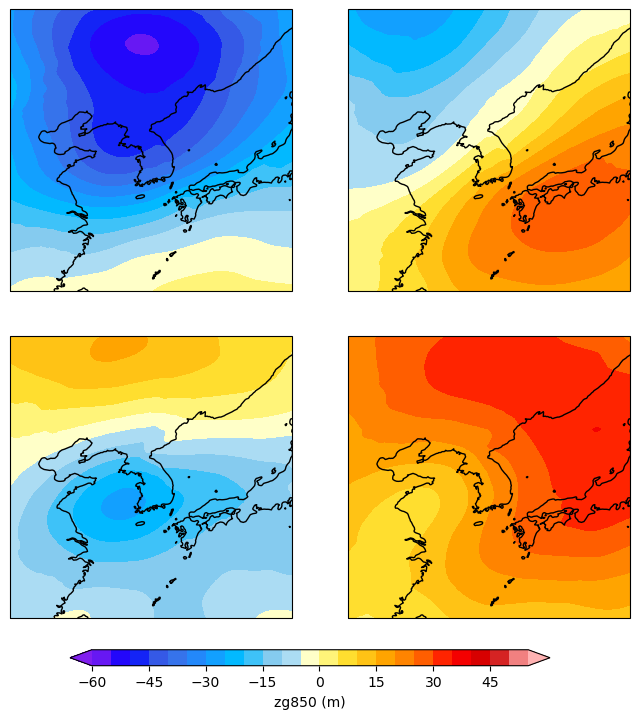

In [12]:
proj = ccrs.PlateCarree()
fig, axs = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': proj})
axs = axs.ravel()
cmap = cmaps.ncl_default

for iclust, ax in enumerate(axs):
    time_clust = data_cluster.iloc[:npts[iclust],iclust].tolist()
    zg_clust_data = inf2['zg850'].sel(time=time_clust, latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))
    zg_clust_comp = zg_clust_data.mean(dim='time')
    lon = zg_clust_comp['longitude'].values
    lat = zg_clust_comp['latitude'].values
    levels = np.arange(-60,60,5)
    contour = ax.contourf(lon, lat, zg_clust_comp, transform=ccrs.PlateCarree(),
                          levels=levels,
                          cmap=cmap, extend='both')
    ax.coastlines()
    del(time_clust,zg_clust_data)

cax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
cbar = plt.colorbar(contour, cax = cax, orientation='horizontal',pad=0.05,shrink=0.9)
cbar.set_label('zg850 (m)')
plt.subplots_adjust(bottom=0.1, hspace=0.1)
plt.show()
plt.close()